### 通过手动求导来实现线性回归


/home/yy/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


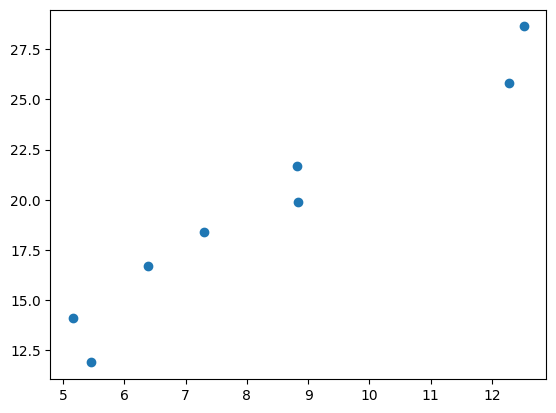

In [1]:
import  torch as t
from  torch.autograd import Variable as  V
from matplotlib import pyplot as plt

# 随机数种子
t.manual_seed(1000)
# 生成数据
real_w =2
real_b = 3
def get_fake_data(batch_size=8):
    # [8,1]shape的随机数 
    # y = 2*x +3 添加噪声
    x = t.rand(batch_size,1)*20
    sigma = t.randn(batch_size,1)
  
    y = x*real_w+real_b+sigma
    
    return x,y


x,y = get_fake_data()
plt.scatter(x.squeeze().numpy(),y.squeeze().numpy())

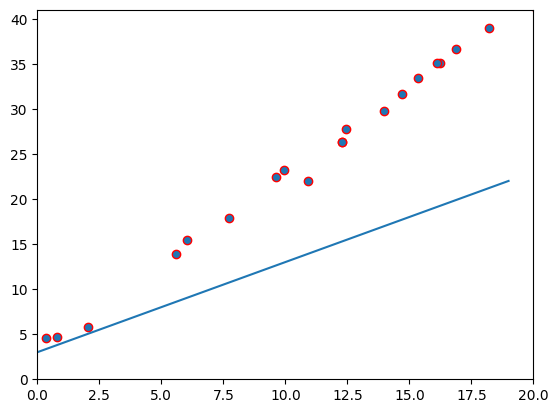

实际值：w: 2 b: 3
预测值：w: 2.0319371223449707 b: 3.0130093097686768


In [2]:
from IPython import display
# 随机初始化参数
w = t.rand(1,1)
b = t.zeros(1,1)

# 学习率(尽可能小，大容易跑飞)
lr =0.001

for li in range(30000):
    x,y = get_fake_data()
    
    # forward 计算loss
    # y = w*x +b
    y_pred = x.mm(w) + b.expand_as(y)
    # loss = 1/2(y_pred-y)**2 均方误差
    loss = 0.5*(y_pred-y)**2 
    loss = loss.sum()
    
    # backward
    # 自动
    dloss = 1
    dpre_y = dloss * (y_pred-y)
    # 转置
    dw = x.t().mm(dpre_y)
    db = dpre_y.sum()

    
    # 更新参数  
    w -= lr * dw
    b -= lr * db
    


    if li % 1000 == 0:
        # 更新输出显示
        display.clear_output(wait=True)
        # 生成 [0，20]的随机数
        x =t.arange(0,20).view(-1,1)
        y = x.mm(w.long()) +b.expand_as(x)
        # predict
        plt.plot(x.numpy(),y.numpy())
        x2,y2 = get_fake_data(20)
        # True data
        plt.scatter(x2.numpy(),y2.numpy(),edgecolors='red')
        plt.xlim(0,20)
        plt.ylim(0,41)
        plt.show()
        plt.pause(0.5)
print('实际值：w: {} b: {}'.format(real_w,real_b))        
print('预测值：w: {} b: {}'.format(w.item(),b.item()))

### 通过 Variable 来实现线性回归

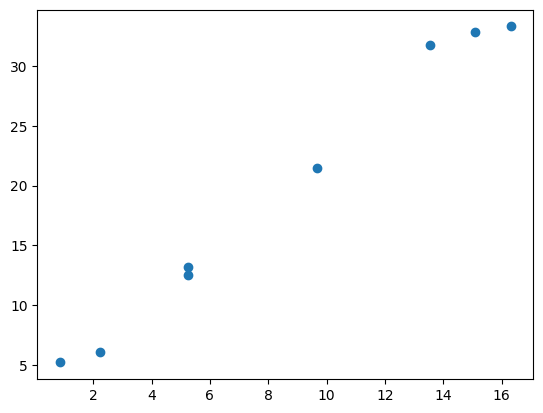

In [3]:
import  torch as t
from  torch.autograd import Variable as  V
from matplotlib import pyplot as plt

# 随机数种子
t.manual_seed(100)
# 生成数据
def get_fake_data(batch_size=8):
    # [8,1]shape的随机数 
    # y = 2*x +3 添加噪声
    x = t.rand(batch_size,1)*20
    sigma = t.randn(batch_size,1)
    y = x*2+3+sigma
    
    return x,y


x,y = get_fake_data()
plt.scatter(x.squeeze().numpy(),y.squeeze().numpy())

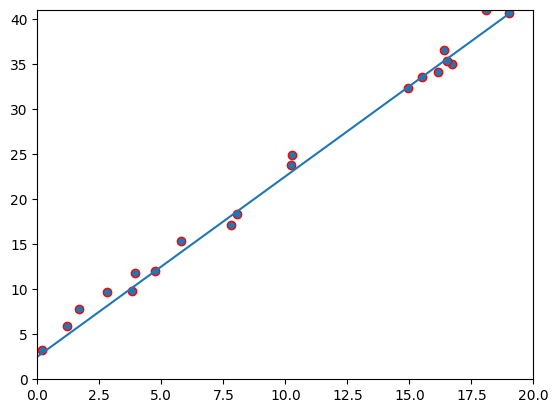

实际值：w: 2 b: 3
预测值：w: 2.0254814624786377 b: 2.592547655105591


In [4]:
from IPython import display
# 随机初始化参数
w = V(t.rand(1,1),requires_grad =True)
b = V(t.zeros(1,1),requires_grad =True)

lr =0.0001

for li in range(10000):
    x,y = get_fake_data()
    # 变为 variable 类型便于求导
    x,y = V(x),V(y)
    
    # forward 计算loss
    # y = w*x +b
    y_pred = x.mm(w) +b.expand_as(y)
    # loss = 1/2(y_pred-y)**2 均方误差
    loss = 0.5*(y_pred-y)**2 
    loss = loss.sum()
    
    # backward
    # 自动
    loss.backward()
    
    ''' 手动
    dloss = 1
    dy_pred = dloss(y_pred-y)
    '''
    
    
    # 更新参数
    
    w.data.sub_(lr*w.grad.data)
    b.data.sub_(lr*b.grad.data)
    
    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()

    if li % 1000 == 0:
        # 更新输出显示
        display.clear_output(wait=True)
        # 生成 [0,20]的随机数
        x =t.arange(0,20).view(-1,1)
        y = x.mm(w.long())+b.expand_as(x)
        # predict
        plt.plot(x.data.numpy(),y.data.numpy())
        x2,y2 = get_fake_data(20)
        # True data
        plt.scatter(x2.numpy(),y2.numpy(),edgecolors='red')
        plt.xlim(0,20)
        plt.ylim(0,41)
        plt.show()
        plt.pause(0.5)
        
print('实际值:w: {} b: {}'.format(real_w,real_b))        
print('预测值:w: {} b: {}'.format(w.item(),b.item()))

## 神经网络工具箱

In [5]:
from torch import nn
class myLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(myLinear, self).__init__()
        # 生成随机 w
        self.w = nn.Parameter(t.randn(in_feature, out_feature))
        # 生成随机 b
        self.b = nn.Parameter(t.randn(out_feature))

    def forward(self, x):
        # wx 
        x = x.mm(self.w) 
        # 将b的shape拓展与x一样
        y = x + self.b.expand_as(x)
        return y
    
layer = myLinear(4,3)
# in_feature:3 out_feature:4
input = V(t.randn(2,4))
output = layer(input)
print(output)

tensor([[-0.0322, -0.8596, -1.4972],
        [ 0.5273, -1.8709, -1.3580]], grad_fn=<AddBackward0>)


输出参数名称和值

In [6]:
for name,parameter in layer.named_parameters():
    print(name,parameter)

w Parameter containing:
tensor([[-0.1283,  1.4052, -0.5557],
        [-0.6897, -1.1787,  0.3515],
        [-0.6532, -0.0314,  0.1473],
        [-0.3748,  0.7667, -0.0835]], requires_grad=True)
b Parameter containing:
tensor([-0.3053, -0.8924, -1.5833], requires_grad=True)


In [7]:
kernerl = t.ones(3,3)/-9
kernerl

tensor([[-0.1111, -0.1111, -0.1111],
        [-0.1111, -0.1111, -0.1111],
        [-0.1111, -0.1111, -0.1111]])

#### 卷积的例子
卷积的`weight`是可学习参数当然也可以用户直接指定

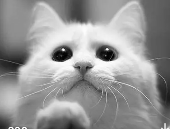

In [8]:
from torchvision import transforms as T
from PIL import Image

img_path = '../image/cat.png'
img_pil = Image.open(img_path).convert('L')
#img_pil = Image.open(img_path).convert('RGB')
img_pil

torch.Size([1, 1, 129, 170])


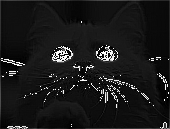

In [9]:
# 输入是一个数据，将其伪装为batch_size = 1 的输入
trans = T.ToTensor()
input = trans(img_pil).unsqueeze(0)
print(input.shape)
# 自定义卷积核数据
# kernel = t.ones(3,3,3,3)/-9
# kernel[0][1][1],kernel[1][1][1],kernel[2][1][1] =1,1,1
kernel = t.ones(3,3)/-9
kernel[1][1]=1
conv = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1,bias=False)
conv.weight.data = kernel.view(1,1,3,3)
out = conv(input)
trans = T.ToPILImage()
img_pil = trans(out.squeeze())
img_pil

In [10]:
# 卷积核的shape
conv_test = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=5)
conv_test.weight.data.shape

torch.Size([3, 2, 5, 5])

**池化层**可以看作一种特殊的卷积层，用来下采样，但是池化层没有可学习的参数，其`weight`是固定的

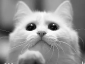

In [11]:
# 平均池化
pool = nn.AvgPool2d(2,2)
output = pool(input)
img = trans(output.squeeze())
img

**Linear层**：全连接层

In [12]:
input = V(t.randn(2,5))
layer = nn.Linear(5,4)
output = layer(input)
print(output,'\n',output.shape)

tensor([[-0.0156, -0.5020,  0.1730,  0.5301],
        [-1.3055,  0.1540, -0.6861, -0.4715]], grad_fn=<AddmmBackward0>) 
 torch.Size([2, 4])


**BatchNorm**：批量规范化层

In [13]:
# 4 channel 初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4)*4
bn.bias.data = t.zeros(4)

bn_out = bn(output)

# 输出均值和方差
# 方差是标准差的平方，计算无偏差分母会减一
# 使用 unbiased=False ，分母不减一

bn_out.mean(0),bn_out.var(0,unbiased=False)

(tensor([ 1.1921e-07,  1.1921e-07, -1.1921e-07,  0.0000e+00],
        grad_fn=<MeanBackward1>),
 tensor([15.9996, 15.9985, 15.9991, 15.9994], grad_fn=<VarBackward0>))

**Dropout层**:防止过拟合

In [14]:
drop = nn.Dropout(0.5)

print('原始数据：\n',bn_out)
print('失活数据：\n',drop(bn_out))


原始数据：
 tensor([[ 4.0000, -3.9998,  3.9999,  3.9999],
        [-4.0000,  3.9998, -3.9999, -3.9999]],
       grad_fn=<NativeBatchNormBackward0>)
失活数据：
 tensor([[0.0000, -0.0000, 0.0000, 7.9998],
        [-0.0000, 7.9996, -0.0000, -0.0000]], grad_fn=<MulBackward0>)


**激活函数**:

激活函数可作为单独的`layer`来使用，此次使用`ReLU`激活函数

In [15]:
relu = nn.ReLU(inplace =True)
input = t.randn(2,3)
print('初始值：\n',input)
print('激活之后的值：\n',relu(input))

初始值：
 tensor([[ 0.5552,  0.8520, -0.2850],
        [ 1.1317, -0.8972,  0.3180]])
激活之后的值：
 tensor([[0.5552, 0.8520, 0.0000],
        [1.1317, 0.0000, 0.3180]])


**损失函数**:

用于衡量预测值和真实值之间的误差，对修正预测值有参考作用

In [16]:
# 3个样本，两个类别
score = V(t.randn(3,2))
# 三个样本分别属于[1,0,1],且必须为LongTensor
label = V(t.Tensor([1,0,1])).long()
criterion = nn.CrossEntropyLoss()
loss = criterion(score,label)
print(loss.item())

0.5108206868171692


#### 优化器

- 对模型的不同部分使用不同的训练参数

```python
        optimizer = optim.SGD([
    {'params':net.feature.parameters()},
    {'params':net.classifier.parameters(),'lr':1e-2}
    ],lr=1e-5)

```

- 调整学习率
    1. 修改参数值中的学习率
    2. 新建优化器
    ```python

    old_lr = 0.1
    optimizer = optim.SGD([
        {'params':net.feature.parameters()},
        {'params':net.classifier.parameters(),'lr':old_lr*0.1}
    ],lr=1e-5)

    ```

In [17]:
from torch import optim
# 定义一个LeNet网络
class Lenet(nn.Module):
    def __init__(self,class_num=10):
        super(Lenet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, class_num)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x
net = Lenet(class_num=8)
print(net)

# 选择优化器
optimizer = optim.SGD(params=net.parameters(),lr=1)

# 梯度清零
optimizer.zero_grad()

input = V(t.randn(1,3,32,32),requires_grad=True)


output = net(input)
# 反向传播
output.backward(output)
# 优化
optimizer.step()


# 为不同的子网络设置不同的学习率
# 某个参数不指定学习率(默认:1e-5)
optimizer = optim.SGD([
    {'params':net.feature.parameters()},
    {'params':net.classifier.parameters(),'lr':1e-2}
],lr=1e-5)
# 只为 两个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.classifier[0],net.classifier[3]])
special_layers_params = list(map(id,special_layers.parameters()))

# 其余层（网络参数不包含连接层）
base_param = filter(lambda p:id(p) not in special_layers_params, net.parameters())
optimizer = t.optim.SGD([
    {'params':base_param},
    {'params':special_layers.parameters(),'lr':0.01}
],lr=0.001)

Lenet(
  (feature): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=8, bias=True)
  )
)


#### nn.functional与nn.Module

- functional:普通的函数，实用没参数学习的layer
- nn.Module:会自动提取学习的参数，并且可区分推理(`net.train`)\验证(`net.eval`)阶段

参数的初始化

In [18]:
for name,params in net.named_parameters():
    print(name)

    if name.find('feature') != -1:
        # Conv layer
        #print(params[0]) # weight
        #print(params[1]) # bias
        pass
    elif name.find('classifier')!= -1:
        # Linear layer 可以自定义设置
        print(params[0]) # weight
        print(params[1]) # bias
    else:
        pass

feature.0.weight
feature.0.bias
feature.3.weight
feature.3.bias
classifier.0.weight
tensor([ 0.0387, -0.0437,  0.0100, -0.0162, -0.0126, -0.0074, -0.0176, -0.0047,
        -0.0041,  0.0161, -0.0254, -0.0486, -0.0234, -0.0332, -0.0275, -0.0382,
        -0.0343,  0.0306,  0.0361,  0.0017, -0.0186,  0.0388, -0.0435, -0.0331,
        -0.0101, -0.0249,  0.0496, -0.0335, -0.0233,  0.0495, -0.0401, -0.0425,
        -0.0338, -0.0215, -0.0266,  0.0038, -0.0432, -0.0275, -0.0298,  0.0181,
        -0.0149, -0.0383, -0.0200,  0.0259, -0.0287,  0.0149, -0.0322,  0.0422,
        -0.0383, -0.0405, -0.0408, -0.0357, -0.0417, -0.0082,  0.0028, -0.0029,
         0.0221,  0.0169, -0.0167, -0.0420, -0.0135, -0.0385, -0.0031,  0.0428,
         0.0335, -0.0106,  0.0371, -0.0028, -0.0292,  0.0426,  0.0240,  0.0205,
         0.0491,  0.0399, -0.0204,  0.0058, -0.0067,  0.0018,  0.0377,  0.0107,
         0.0232,  0.0211,  0.0320, -0.0311, -0.0305, -0.0489, -0.0130, -0.0480,
         0.0394,  0.0199, -0.0031,  

# Python中常用的工具


在训练神经网络的时候最重要的三个工具:数据,可视化，GPU加速

## 数据处理

在Pytorch中，数据加载可通过自定义的数据集对象实现。数据集对象被抽象为Dataset类，实现自定义的数据需要继承Dataset,并实现Python的两个魔法方法：

- \__getitem\__:返回一个数据\样本，obj[index]==obj.\__getitem__(index)
- \__len\__:返回样本的数量,len(obj)==obj.\__len\__

In [27]:
import os
import numpy as np
from torch.utils import data

class DogandCat(data.Dataset):
    def __init__(self,root):
        # 将每个图像以根路径+图像名称保存
        # ['../dataset/dogs-vs-cats/test1/11107.jpg', '../dataset/dogs-vs-cats/test1/11697.jpg', '../dataset/dogs-vs-cats/test1/2899.jpg', ]
        self.imgs = [os.path.join(root,img) for img in   os.listdir(root)]
    # 返回数据和标签值
    def __getitem__(self,index):
        img_path = self.imgs[index]
        # dog:1 cat:0
        label = 1 if 'cat' in img_path.split('/')[-1] else 0 
        pil_img = Image.open(img_path)
        # 将 PIL格式的图片变为 ndarray
        array = np.asarray(pil_img)
        # ndarray -->torch
        data = t.from_numpy(array)
        return data ,label
    # 返回数据的长度
    def __len__(self):
        return len(self.imgs)
dataset_path = '../dataset/dogs-vs-cats/test1/'
dataset =  DogandCat(dataset_path)

img,label = dataset[0] #  相当于调用datatse.__getitem__(0)

imgs = [os.path.join(dataset_path,img) for img in   os.listdir(dataset_path)]

print(len(imgs),imgs[0])


count = 1
for img,label in dataset:
    count +=1
    print(img.size(),label)
    if count ==10:
        break

9105 ../dataset/dogs-vs-cats/test1/11107.jpg
torch.Size([499, 330, 3]) 0
torch.Size([200, 201, 3]) 0
torch.Size([377, 499, 3]) 0
torch.Size([316, 230, 3]) 1
torch.Size([375, 499, 3]) 0
torch.Size([336, 447, 3]) 0
torch.Size([253, 270, 3]) 0
torch.Size([298, 349, 3]) 0
torch.Size([374, 500, 3]) 0


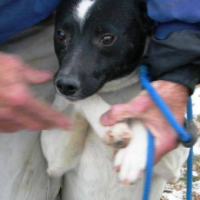

In [60]:
from torchvision import transforms as T
img_path = '../dataset/dogs-vs-cats/test1/1.jpg'
img = Image.open(img_path)
trans = T.Compose([
        T.Resize(224),
        T.CenterCrop(200)])
img_modify = trans(img)
img_modify

对图像随机翻转

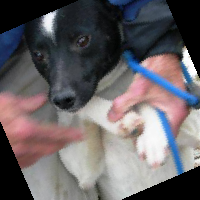

In [61]:
import random
# 对图像随机翻转
trans =T.Lambda(lambda img: img.rotate(random.random()*360))
img_rotate = trans(img_modify)
img_rotate

通过ImageFolder对数据集操作

- 要求打开的文件夹下每个图像按不同文件夹保存
    - cat
        - cat.1.jpg
        - cat.2.jpg
    - dog
        - dog.1.jpg
        - dog.2.jpg

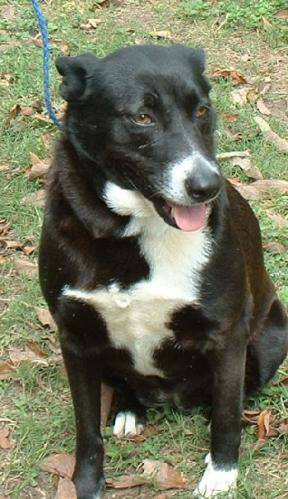

In [80]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('../dataset/dogs-vs-cats/')

# [样本][标签]
dataset[3][0]

打开数据集文件，并加上Transform操作

In [91]:
normal = T.Normalize(mean=[0.5,0.5,0.5],std=[0.2,0.2,0.2])
transform = T.Compose([
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normal
])

dataset = ImageFolder('../dataset/dogs-vs-cats/',transform=transform)
dataset[1][0].size()

torch.Size([3, 224, 224])

还原图片格式

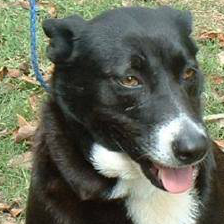

In [94]:
to_img =T.ToPILImage()
# 乘标准差 + 平均值|
to_img(dataset[3][0]*0.2+0.5)

处理样本异常的问题
1. 返回None对象，在Dataloade中自定义collate_fn，将空对象过滤(样本数据-1)
2. 随机抽取一张图替代

In [114]:
'''method 1'''
# 继承前面实现的DogCat数据集
class NewDogCat(DogandCat):
    def __getitem__(self,index):
        try:
            # 调用父类的获取函数
            return super(NewDogCat,self).__getitem__(index)
        except :
            None,None
            
# 导入默认拼接方式
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader

def my_collect_fn(batch):
    # batch中的数据为 （data，label）
    
    # 过滤为None的数据
    batch = list(filter(lambda x:x[0] is not None ,batch))

    return default_collate(batch)
dataloader =DataLoader(dataset,2,collate_fn=my_collect_fn)

'''method 2'''
class NewDogCat(DogandCat):
    def __getitem__(self,index):
        try:
            return super(NewDogCat,self).__getitem__(index)
        except:
            # 生成图片的随机下标
            new_indent = random.randint(0,len(self)-1)
            return self[new_indent]

## 使用GPU加速

以下数据结构包含CPU和GPU两个版本
- Tensor
- Variable
- nn.Module(常用的layer，loss function)

调用`.cuda()`方法


In [ ]:
tensor =t.ones(2,4)
# 保存数据在第一块 GPU 上，但是原来的 tensor未变
tensor.cuda(0)
tensor.is_cuda

False